In [1]:
N_STEPS_IN = 100
N_STEPS_OUT = 15
N_FEATURES = 1

In [2]:
import pandas as pd
import numpy as np

# Import the dataset and encode the date
df = pd.read_csv("./input/coinbaseUSD_1-min_data_2014-12-01_to_2018-11-11.csv")
df['date'] = pd.to_datetime(df['Timestamp'],unit='s').dt.date
group = df.groupby('date')
Real_Price = group['Weighted_Price'].mean()

In [4]:
df_train= Real_Price[:-(N_STEPS_IN+N_STEPS_OUT)]
df_test= Real_Price[-(N_STEPS_IN+N_STEPS_OUT):]

In [5]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_set = df_train.values
train_set = np.reshape(train_set, (len(train_set), 1))
train_set = sc.fit_transform(train_set)
train_set = np.reshape(train_set, (len(train_set),))

test_set = df_test.values
test_set = np.reshape(test_set, (len(test_set), 1))
test_set = sc.transform(test_set)
test_set = np.reshape(test_set, (len(test_set),))

In [8]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X_train, y_train = split_sequence(train_set, N_STEPS_IN, N_STEPS_OUT)
X_test, y_test = split_sequence(test_set, N_STEPS_IN, N_STEPS_OUT)

In [9]:
# reshaping X_train and X_test
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], N_FEATURES))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], N_FEATURES))

In [10]:
# univariate multi-step vector-output stacked lstm example
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(N_STEPS_IN, N_FEATURES)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(N_STEPS_OUT))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1179/1179 [==============================] - 5s 4ms/step - loss: 0.0323
Epoch 2/50
1179/1179 [==============================] - 4s 3ms/step - loss: 0.0047
Epoch 3/50
1179/1179 [==============================] - 4s 3ms/step - loss: 0.0032
Epoch 4/50
1179/1179 [==============================] - 4s 3ms/step - loss: 0.0031
Epoch 5/50
1179/1179 [==============================] - 4s 3ms/step - loss: 0.0028
Epoch 6/50
1179/1179 [==============================] - 4s 3ms/step - loss: 0.0029
Epoch 7/50
1179/1179 [==============================] - 4s 3ms/step - loss: 0.0026
Epoch 8/50
1179/1179 [==============================] - 4s 3ms/step - loss: 0.0024
Epoch 9/50
1179/1179 [==============================] - 4s 3ms/step - loss: 0.0024
Epoch 10/50
1179/1179 [==============================] - 4s 3ms/step - loss: 0.0024
Epoch 11/50
1179/1179 [==========================

In [11]:
# predict
predicted_BTC_price = model.predict(X_test)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)[0]
predicted_BTC_price

array([6176.7524, 6387.916 , 6451.1274, 6360.49  , 6514.3623, 6765.823 ,
       6761.4263, 6846.539 , 6926.4756, 7105.2017, 7207.527 , 7272.8857,
       7223.245 , 7381.683 , 7666.4404], dtype=float32)

In [12]:
y_test_ = sc.inverse_transform(y_test)[0]

In [13]:
df_test[-N_STEPS_OUT:].values

array([6403.7060758 , 6330.39529072, 6264.15238345, 6275.53314287,
       6310.06296416, 6353.55880287, 6335.43545431, 6365.4440852 ,
       6405.16073387, 6413.22721536, 6506.2263592 , 6451.01455815,
       6366.78033543, 6355.67522903, 6347.4174389 ])

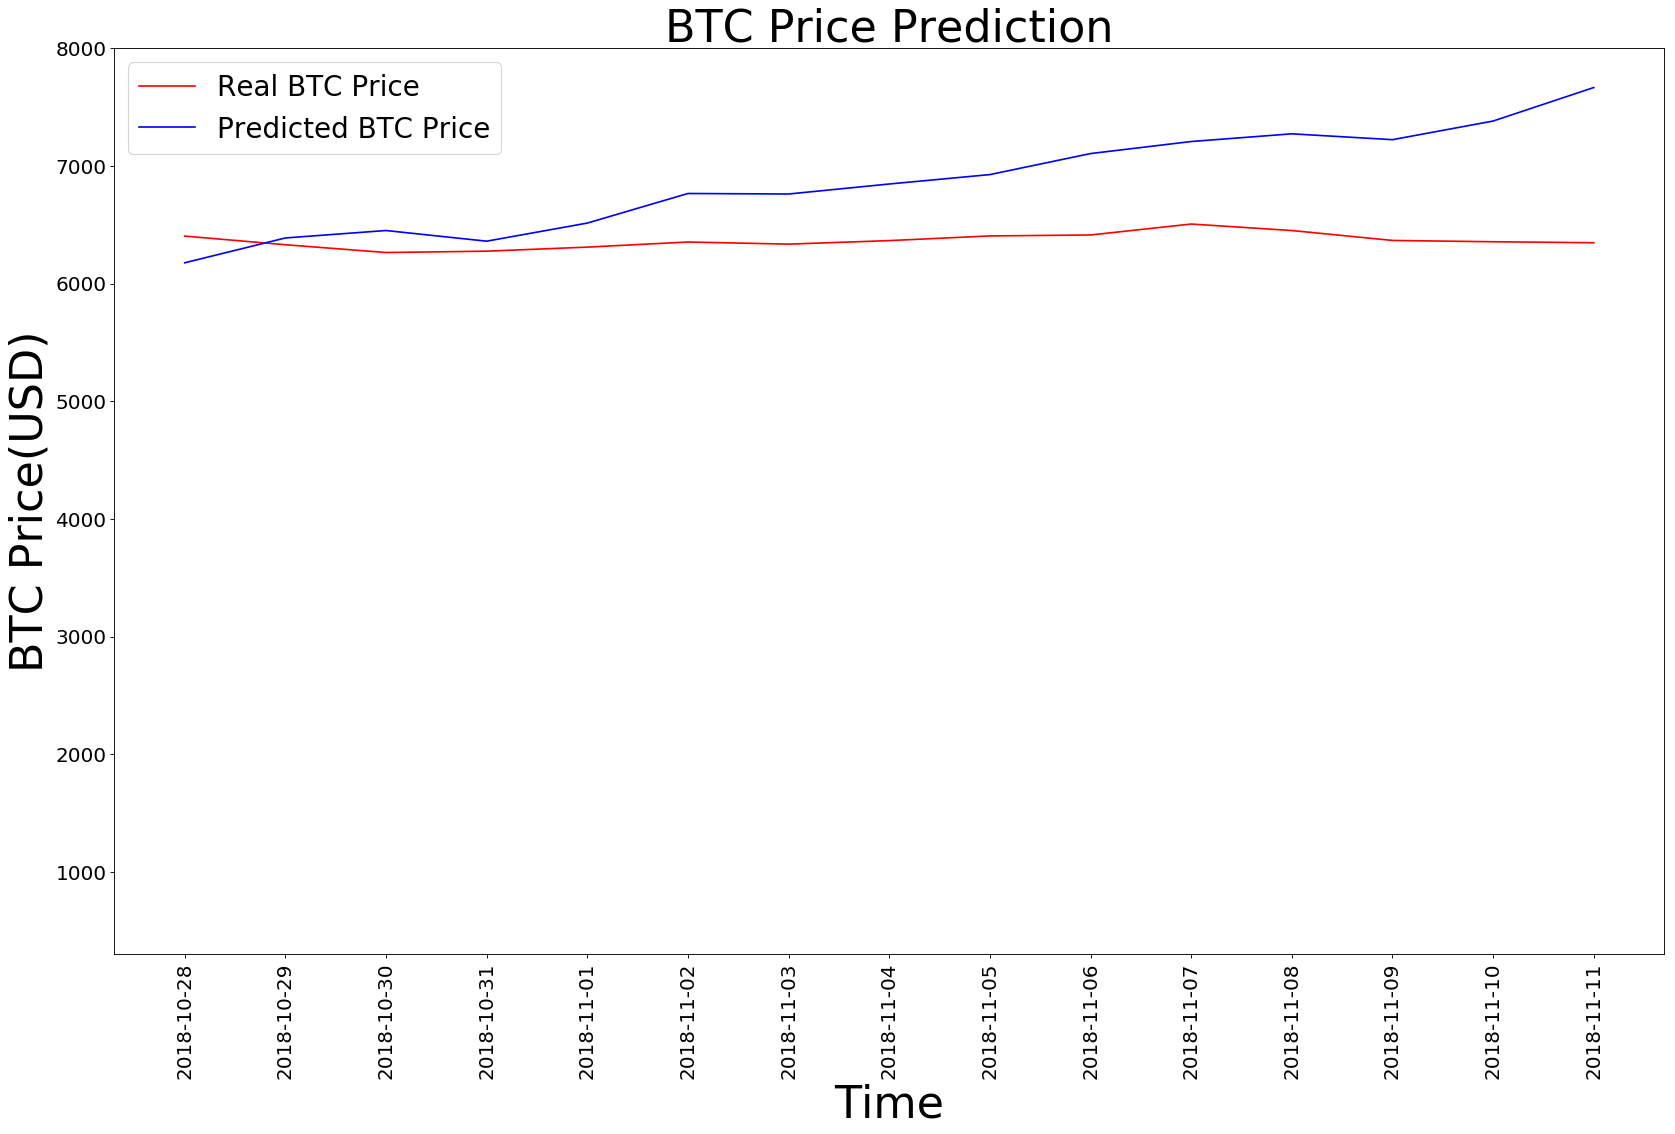

In [16]:
from matplotlib import pyplot as plt

plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()
ax.set_ylim([300,8000])
plt.plot(y_test_, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)
df_test_reset = df_test[-N_STEPS_OUT:].reset_index()
x=df_test_reset.index
labels = df_test_reset['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

In [17]:
score = model.evaluate(X_test, y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[0], score*100))

1/1 [==============================] - 0s 162ms/step
loss: 0.11%
